In [1]:
from typing import TypedDict, Annotated, Dict
from langgraph.graph import add_messages, StateGraph, END, START
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

In [2]:
load_dotenv()

True

In [3]:
class ChildState(TypedDict):
    messages: Annotated[list, add_messages]

In [4]:
search_tool=TavilySearchResults(max_results=2)

In [5]:
tools=[search_tool]

In [6]:
llmLlama=ChatGroq(model="llama-3.1-8b-instant")

In [7]:
# illustrations
llmLlama.invoke(input="Who is SRT?")

AIMessage(content="SRT can refer to several things, but I'll provide a few possibilities:\n\n1. **Street Racing Technology**: SRT is an American manufacturer of high-performance vehicles, which was previously a division of Chrysler. SRT stood for Street and Racing Technology. The company was later merged with Dodge Performance to form SRT Performance, but in 2020, it was reorganized as a performance brand within Stellantis, and it's now known as Dodge//SRT Performance.\n\n2. **Super Racing Team**: SRT is also the name of a team in the GT World Challenge Asia series, competing with an Audi R8 car.\n\n3. **SRT (TV series)**: SRT is also the name of a Hong Kong TV series aired in 1993.\n\n4. **SRT (Organization)**: The Special Response Team, also known as the SRT, is an elite tactical unit within law enforcement agencies in the US, used for high-risk operations.\n\nTo provide a more accurate answer, I would need more context or information about the 'SRT' you are referring to.", additiona

In [8]:
llm_with_tools=llmLlama.bind_tools(tools=tools)

In [9]:
# illustration
t=llm_with_tools.invoke(input="What's the temperature at Kharagpur now?")
t

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kyt4', 'function': {'arguments': '{"query": "Current temperature in Kharagpur"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 577, 'total_tokens': 601, 'completion_time': 0.032810374, 'prompt_time': 0.027947442, 'queue_time': -0.060318752, 'total_time': 0.060757816}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_a4265e44d5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-bad744b3-b0cb-4365-a791-2814034700e3-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Current temperature in Kharagpur'}, 'id': 'call_kyt4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 577, 'output_tokens': 24, 'total_tokens': 601})

In [10]:
# illustration
search_tool.invoke(t.tool_calls[0]['args']['query'])

[{'title': 'Kharagpur Weather Today and AQI Level',
  'url': 'https://www.businesstoday.in/weather/kharagpur-weather-forecast-today',
  'content': "Today's minimum temperature in Kharagpur is recorded at 28°c (degrees celsius), and the maximum temperature is expected to go as high as 40°c (degrees celsius).",
  'score': 0.88564163},
 {'title': 'Current Weather - Kharagpur, West Bengal - AccuWeather',
  'url': 'https://www.accuweather.com/en/in/kharagpur/191582/current-weather/191582',
  'content': 'Current Weather · 96°F Mostly sunny · RealFeel® 107°. Very Hot. RealFeel Guide. Very Hot. 101° to 107°. Caution advised. Danger of dehydration, heat stroke, heat',
  'score': 0.8684817}]

In [11]:
def agent(state:ChildState):
    state["messages"]=llm_with_tools.invoke(input=state["messages"])
    return state

In [12]:
def tools_router(state: ChildState):
    print(f"State prior to tool calling: {state}\n")
    last_message=state["messages"][-1]
    if (hasattr(last_message,"tool_calls")) and len(last_message.tool_calls)>0:
        return "tool_node"
    else:
        return "end"

In [13]:
tool_node=ToolNode(tools=tools)

In [14]:
subGraph=StateGraph(state_schema=ChildState)

In [15]:
subGraph.add_node(node="agent",action=agent)

In [16]:
subGraph.add_node(node="tool_node", action=tool_node)

In [17]:
subGraph.add_conditional_edges(source="agent",path=tools_router,
                               path_map={"tool_node":"tool_node","end":END}
                              )

In [18]:
subGraph.add_edge(start_key="tool_node",end_key="agent")

In [19]:
subGraph.set_entry_point(key="agent")

In [20]:
search_app=subGraph.compile()

In [21]:
print(search_app.get_graph().print_ascii())

          +-----------+           
          | __start__ |           
          +-----------+           
                 *                
                 *                
                 *                
            +-------+             
            | agent |             
            +-------+.            
           **         ..          
         **             ..        
        *                 .       
+-----------+         +---------+ 
| tool_node |         | __end__ | 
+-----------+         +---------+ 
None


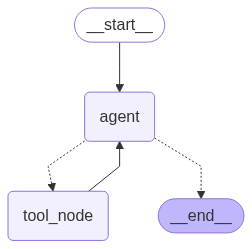

In [22]:
display(Image(data=search_app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [23]:
response=search_app.invoke(input={"messages":"How is the weather in Chennai?"})

State prior to tool calling: {'messages': [HumanMessage(content='How is the weather in Chennai?', additional_kwargs={}, response_metadata={}, id='7e9eaf78-5d01-43ce-97d6-af71f45fa868'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7bdh', 'function': {'arguments': '{"query": "Chennai weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 285, 'total_tokens': 305, 'completion_time': 0.027304153, 'prompt_time': 0.008940262, 'queue_time': 0.051525458, 'total_time': 0.036244415}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_a4265e44d5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-308d5f6f-7301-4b32-b2b2-28006c5735a4-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Chennai weather'}, 'id': 'call_7bdh', 'type': 'tool_call'}], usage_metadata={'input_tokens': 285, 'output_tokens': 20, 'total_tokens': 305})]}

State prio

In [23]:
response

{'messages': [HumanMessage(content='How is the weather in Chennai?', additional_kwargs={}, response_metadata={}, id='5efbea3e-b370-4ee5-8000-4a50d82151b1'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jjcr', 'function': {'arguments': '{"query": "Chennai weather today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 569, 'total_tokens': 590, 'completion_time': 0.028, 'prompt_time': 0.053183176, 'queue_time': -0.080358165, 'total_time': 0.081183176}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f7bd09b454', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4bea0d8e-47fa-4d10-b34f-23ffe6cdb068-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Chennai weather today'}, 'id': 'call_jjcr', 'type': 'tool_call'}], usage_metadata={'input_tokens': 569, 'output_tokens': 21, 'total_tokens': 590}),
  ToolMessage(content='[{"title"

<h3>Shared Schema, direct embedding</h3>

In [34]:
class ParentState(TypedDict):
    messages:Annotated[list, add_messages]

In [35]:
# Create a parent graph
parent_graph=StateGraph(state_schema=ParentState)

In [36]:
# Add the subgraph as a node
parent_graph.add_node(node="search_agent",action=search_app)

In [37]:
# connect the flow
parent_graph.add_edge(start_key=START,end_key="search_agent")

In [38]:
# connect the flow
parent_graph.add_edge(start_key="search_agent",end_key=END)

In [39]:
# Compile the parent graph
parent_app=parent_graph.compile()

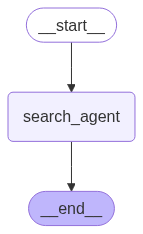

In [40]:
display(Image(data=parent_app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [41]:
response=parent_app.invoke(input={"messages":"How is the weather in Kolkata?"})

State prior to tool calling: {'messages': [HumanMessage(content='How is the weather in Kolkata?', additional_kwargs={}, response_metadata={}, id='35f7712b-fafd-4dc2-b9a3-98a6b65e4c92'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_91vd', 'function': {'arguments': '{"query": "Kolkata weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 285, 'total_tokens': 306, 'completion_time': 0.028, 'prompt_time': 0.030523356, 'queue_time': 0.148740174, 'total_time': 0.058523356}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f7bd09b454', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-06591afe-4ca7-4cbf-ae74-087acf6c0995-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Kolkata weather'}, 'id': 'call_91vd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 285, 'output_tokens': 21, 'total_tokens': 306})]}

State prior to t

In [42]:
response

{'messages': [HumanMessage(content='How is the weather in Kolkata?', additional_kwargs={}, response_metadata={}, id='35f7712b-fafd-4dc2-b9a3-98a6b65e4c92'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_91vd', 'function': {'arguments': '{"query": "Kolkata weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 285, 'total_tokens': 306, 'completion_time': 0.028, 'prompt_time': 0.030523356, 'queue_time': 0.148740174, 'total_time': 0.058523356}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f7bd09b454', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-06591afe-4ca7-4cbf-ae74-087acf6c0995-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Kolkata weather'}, 'id': 'call_91vd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 285, 'output_tokens': 21, 'total_tokens': 306}),
  ToolMessage(content='[{"title": "Weather in

<h3>Different Schema (Invoke with Transformation)</h3>

In [44]:
# define parent graph with a different scheme
class QueryState(TypedDict):
    query: str
    response: str

In [45]:
# Function to invoke a Subgraph
def search_agent(state: QueryState) -> Dict:
    # Transform from parent schema to Subgraph schema
    subgraph_input={"messages":[state['query']]}
    # Invoke the subgraph
    subgraph_result=search_app.invoke(input=subgraph_input)

    state['response']=subgraph_result["messages"][-1].content
    return state

In [46]:
# Create a parent graph
parent_graph=StateGraph(state_schema=QueryState)

In [47]:
# Add transformation node that invokes subgraph
parent_graph.add_node(node="search_agent",action=search_agent)

In [48]:
# connect the flow
parent_graph.add_edge(start_key=START,end_key="search_agent")

In [49]:
# connect the flow
parent_graph.add_edge(start_key="search_agent",end_key=END)

In [50]:
# Compile the parent graph
parent_app=parent_graph.compile()

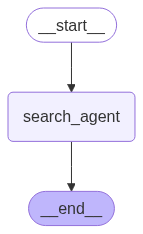

In [51]:
display(Image(data=parent_app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [52]:
response=parent_app.invoke(input={"query":"How is the weather in Kolkata?","response":""})

State prior to tool calling: {'messages': [HumanMessage(content='How is the weather in Kolkata?', additional_kwargs={}, response_metadata={}, id='6eb2872e-0580-4075-ac06-b813b7f2f4c6'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3dqc', 'function': {'arguments': '{"query": "Kolkata weather today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 569, 'total_tokens': 590, 'completion_time': 0.028, 'prompt_time': 0.019614572, 'queue_time': -0.045091702, 'total_time': 0.047614572}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f7bd09b454', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-22ef8d41-4f5e-4ce2-8a41-fb9d81a352e5-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Kolkata weather today'}, 'id': 'call_3dqc', 'type': 'tool_call'}], usage_metadata={'input_tokens': 569, 'output_tokens': 21, 'total_tokens': 590})]}

Sta

In [53]:
response

{'query': 'How is the weather in Kolkata?',
 'response': 'The weather in Kolkata is currently mostly sunny with a high of 39 degrees Celsius and a low of 29 degrees Celsius. However, there is a chance of rain or thunderstorms with strong gusty winds. It is recommended to drink plenty of water and stay hydrated due to the high temperatures.'}